## Load an LTSF-Linear Model

Train the model through 'electricity.sh' bash script.
Load an .pth file from the checkpoints folder.

Model(
  (Linear): Linear(in_features=96, out_features=24, bias=True)
) 2328


tensor([[[3971.8933],
         [3360.2705],
         [3204.7512],
         [2988.9539],
         [2929.4128],
         [3070.3926],
         [2896.9194],
         [2649.6338],
         [2998.7996],
         [3615.6736],
         [4151.6294],
         [4905.6621],
         [5415.7915],
         [5113.9780],
         [4746.3276],
         [4419.1621],
         [4399.9644],
         [4683.9780],
         [5425.0605],
         [5884.6802],
         [5812.0562],
         [5504.4868],
         [5133.2739],
         [4612.5591]]], grad_fn=<PermuteBackward0>)


/mnt/zkpet/venv/lib/python3.10/site-packages/torch/_tensor.py:836: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


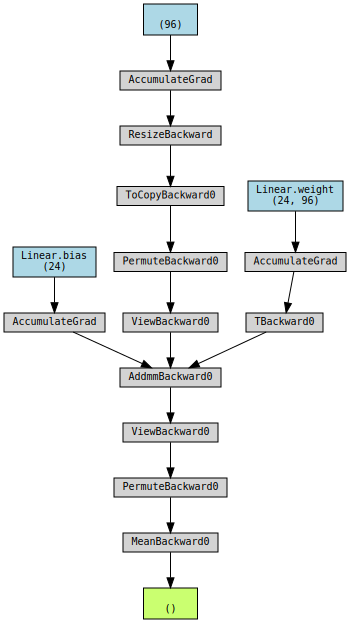

In [23]:
import torch
import onnx
import pandas as pd
import sys
sys.path.append("..")
from models.DLinear import Model as DLinear
from models.Linear import Model as Linear
import torch
from torchviz import make_dot

class Configs:
    def __init__(self, seq_len, pred_len):
      self.seq_len = seq_len
      self.pred_len = pred_len
      self.enc_in = 321
      self.individual = False

target = '40'
seq_len = 96
pred_len = 24

configs = Configs(seq_len, pred_len)
circuit = Linear(configs)
basepath = '../checkpoints/checkpoint_{}_{}_tg{}.pth'
check_point_model = basepath.format(seq_len, pred_len, target)
if int(target) > 50:
    basepath = '../checkpoints/Electricity_{}_{}_Linear_custom_ftS_tg{}_sl{}_ll48_pl{}_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/checkpoint.pth'
    check_point_model = basepath.format(seq_len, pred_len, target, seq_len, pred_len)
state_dict = torch.load(check_point_model)
circuit.load_state_dict(state_dict)

total_params = sum(
	param.numel() for param in circuit.parameters()
)


print(circuit, total_params)

df = pd.read_csv('../dataset/electricity.csv')
# Load the last seq_len entries data as input and converts to tensor
# x = 10*torch.rand(1,*[seq_len, 1], requires_grad=True)
x = torch.tensor(df[target][-seq_len:].values, requires_grad=True).resize(1, seq_len, 1).float()
# Flips the neural net into inference mode
circuit.eval()

y = circuit(x)
print(y)

# Visualize the trained model
make_dot(y.mean(), params=dict(circuit.named_parameters()))

## ZK Inference

#### Define Files Path

In [9]:
import ezkl
import tracemalloc
import os
import json
from timeit import default_timer as timer

model_path = os.path.join('network.onnx')
compiled_model_path = os.path.join('network.ezkl')
pk_path = os.path.join('test.pk')
vk_path = os.path.join('test.vk')
settings_path = os.path.join('settings.json')
srs_path = os.path.join('kzg.srs')
witness_path = os.path.join('witness.json')
data_path = os.path.join('input.json')
proof_path = os.path.join('test.pf')
sol_code_path = os.path.join('verify.sol')
abi_path = os.path.join('verify.abi')

#### Convert Model to ONNX

In [10]:
# Model was trained by 'electricity.sh' and stored into the checkpoint state 'checkpoint.pth'.
# Now we need to export the onnx file from this state file with model inputs.

# Export the model
torch.onnx.export(circuit,               # model being run
                      x,                   # model input (or a tuple for multiple inputs)
                      model_path,            # where to save the model (can be a file or file-like object)
                      export_params=True,        # store the trained parameter weights inside the model file
                      opset_version=10,          # the ONNX version to export the model to
                      do_constant_folding=True,  # whether to execute constant folding for optimization
                      input_names = ['input'],   # the model's input names
                      output_names = ['output'], # the model's output names
                      dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                    'output' : {0 : 'batch_size'}})

data_array = ((x).detach().numpy()).reshape([-1]).tolist()

data = dict(input_data = [data_array])

# Serialize data into file:
json.dump( data, open(data_path, 'w' ))

input_size = os.stat(data_path).st_size / 1024
onnx_size = os.stat(model_path).st_size / 1024
print("Input.json size: {}KB".format(input_size))
print("network.onnx size: {}KB".format(onnx_size))

Input.json size: 0.767578125KB
network.onnx size: 9.5595703125KB


### Setup

In [11]:
import ezkl

run_args = ezkl.PyRunArgs()
# run_args.scale = 17

try:
    table_string = ezkl.table(model_path, run_args)
    print(table_string)
except Exception as e:
    print(f"An error occurred: {e}")

 
┌─────┬──────────────────────────────────────────┬───────────┬──────────────────┬────────────┬────────────────────┐
│ idx │ opkind                                   │ out_scale │ inputs           │ out_dims   │ required_lookups   │
├─────┼──────────────────────────────────────────┼───────────┼──────────────────┼────────────┼────────────────────┤
│ 0   │ Input                                    │ 7         │                  │ [1, 96, 1] │ []                 │
├─────┼──────────────────────────────────────────┼───────────┼──────────────────┼────────────┼────────────────────┤
│ 1   │ CONST (scale=7)                          │ 7         │                  │ [96, 24]   │ []                 │
├─────┼──────────────────────────────────────────┼───────────┼──────────────────┼────────────┼────────────────────┤
│ 2   │ REBASED (div=128.0) (EINSUM akm,kn->anm) │ 7         │ [(0, 0), (1, 0)] │ [1, 24, 1] │ ["DIV(denom=128)"] │
├─────┼──────────────────────────────────────────┼───────────┼────────

In [17]:
# Setup is performed by the application developer, who then deploys the resulting artifacts to production.

!RUST_LOG=trace
# TODO: Dictionary outputs
# Before setup can run, the settings need to be generated with gen-settings
#  and optionally calibrate-settings, and the model must be compiled.

tracemalloc.start()
start = timer()

# res = ezkl.gen_settings(model_path, settings_path)
# assert res == True

# res = ezkl.calibrate_settings(data_path, model_path, settings_path, "resources")
# assert res == True

res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
assert res == True

# Generate KZG srs
res = ezkl.get_srs(srs_path, settings_path)

# HERE WE SETUP THE CIRCUIT PARAMS
# WE GOT KEYS
# WE GOT CIRCUIT PARAMETERS
# EVERYTHING ANYONE HAS EVER NEEDED FOR ZK

res = ezkl.setup(
        compiled_model_path,
        vk_path,
        pk_path,
        srs_path,
    )

assert res == True
assert os.path.isfile(vk_path)
assert os.path.isfile(pk_path)

end = timer()
print("time used: {} seconds.".format(end - start))

snapshot = tracemalloc.take_snapshot()
top_stats = snapshot.statistics('lineno')
print("[ Top 10 ]")
for stat in top_stats[:10]:
    print(stat)

spawning module 2
spawning module 2


time used: 73.54279454797506 seconds.
[ Top 10 ]
/mnt/zkpet/venv/lib/python3.10/site-packages/pandas/core/internals/managers.py:2200: size=64.6 MiB, count=6, average=10.8 MiB
/mnt/zkpet/venv/lib/python3.10/site-packages/pandas/io/parsers/c_parser_wrapper.py:234: size=1750 KiB, count=26363, average=68 B
/usr/lib/python3.10/posixpath.py:373: size=63.7 KiB, count=511, average=128 B
/usr/lib/python3.10/genericpath.py:77: size=51.9 KiB, count=494, average=108 B
/usr/lib/python3.10/tracemalloc.py:558: size=29.5 KiB, count=539, average=56 B
/usr/lib/python3.10/tracemalloc.py:67: size=28.9 KiB, count=463, average=64 B
/usr/lib/python3.10/ast.py:50: size=28.6 KiB, count=454, average=64 B
/mnt/zkpet/venv/lib/python3.10/site-packages/pygments/formatters/terminal256.py:180: size=28.2 KiB, count=418, average=69 B
/usr/lib/python3.10/tracemalloc.py:505: size=26.3 KiB, count=474, average=57 B
/mnt/zkpet/venv/lib/python3.10/site-packages/IPython/core/compilerop.py:174: size=26.2 KiB, count=295, averag

### Prove

In [18]:
# Prove, invoked with ezkl prove at the cli or ezkl.prove() in Python, is called by the prover, often on the client.

# the witness data for the claim: an (input, output) pair (x,y) such that model(input) = output.
# this pair can be produced from x using the gen-witness command.
# now generate the witness file 

tracemalloc.start()
start = timer()
res = ezkl.gen_witness(
        data_path, 
        compiled_model_path, 
        witness_path
      )
# assert os.path.isfile(witness_path)

# GENERATE A PROOF

res = ezkl.prove(
        witness_path,
        compiled_model_path,
        pk_path,
        proof_path,
        srs_path,
        "single"
    )

# print(res)
# assert os.path.isfile(proof_path)

end = timer()
prove_time = end - start
print("time used: {} seconds".format(prove_time))

snapshot = tracemalloc.take_snapshot()
top_stats = snapshot.statistics('lineno')
print("[ Top 10 ]")
for stat in top_stats[:10]:
    print(stat)

proof_size = os.stat(proof_path).st_size / 1024
print("{} size: {}KB".format(proof_path, proof_size))

spawning module 2


time used: 64.825210981071 seconds
[ Top 10 ]
/mnt/zkpet/venv/lib/python3.10/site-packages/pandas/core/internals/managers.py:2200: size=64.6 MiB, count=6, average=10.8 MiB
/mnt/zkpet/venv/lib/python3.10/site-packages/pandas/io/parsers/c_parser_wrapper.py:234: size=1750 KiB, count=26361, average=68 B
/usr/lib/python3.10/posixpath.py:373: size=63.7 KiB, count=511, average=128 B
/usr/lib/python3.10/tracemalloc.py:558: size=62.4 KiB, count=1203, average=53 B
/usr/lib/python3.10/genericpath.py:77: size=51.9 KiB, count=494, average=108 B
/usr/lib/python3.10/tracemalloc.py:67: size=29.5 KiB, count=472, average=64 B
/usr/lib/python3.10/ast.py:50: size=28.6 KiB, count=454, average=64 B
/mnt/zkpet/venv/lib/python3.10/site-packages/pygments/formatters/terminal256.py:180: size=27.5 KiB, count=408, average=69 B
/usr/lib/python3.10/tracemalloc.py:505: size=26.8 KiB, count=484, average=57 B
/mnt/zkpet/venv/lib/python3.10/site-packages/IPython/core/compilerop.py:174: size=26.2 KiB, count=295, average=

### Verify

#### VERIFY off-chain

In [19]:
start = timer()
res = ezkl.verify(
        proof_path,
        settings_path,
        vk_path,
        srs_path,
    )

assert res == True
print("verified")
end = timer()
print("time used: {} seconds".format(end - start))

verified
time used: 1.2481809575110674 seconds


#### VERIFY on-chain

In [20]:
# Create verifier contract
res = ezkl.create_evm_verifier(
        vk_path,
        srs_path,
        settings_path,
        sol_code_path,
        abi_path,
    )
verifier_size = os.stat(sol_code_path).st_size / 1024
print("{} size: {}KB".format(sol_code_path, verifier_size))

verify.sol size: 56.1884765625KB


In [21]:
# Deploy the verifier contract onchain
sol_code_path = os.path.join("verify.sol")
address_path = os.path.join('contractAddr.txt')
# assuming anvil is running
res = ezkl.deploy_evm(
    address_path,
    sol_code_path
)

In [29]:
# Verify proof onchain

# with open(address_path, 'r') as f:
#   addr = f.readline()

# res = ezkl.verify_evm(
#     proof_path,
#     addr
# )

## Stats

In [22]:
input_size = os.stat(data_path).st_size / 1024
onnx_size = os.stat(model_path).st_size / 1024
print("{} size: {}KB".format(data_path, input_size))
print("{} size: {}KB".format(model_path, onnx_size))
proof_size = os.stat(proof_path).st_size / 1024
print("{} size: {}KB".format(proof_path, proof_size))
print("prove time used: {} seconds".format(prove_time))
verifier_size = os.stat(sol_code_path).st_size / 1024
print("{} size: {}KB".format(sol_code_path, verifier_size))

input.json size: 0.767578125KB
network.onnx size: 9.5595703125KB
test.pf size: 21.935546875KB
prove time used: 64.825210981071 seconds
verify.sol size: 56.1884765625KB
